<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from sklearn import preprocessing
%matplotlib inline

# all needed logarithms library are mentioned here
from sklearn import svm, metrics, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.externals.six import StringIO
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
# import pydotplus
import matplotlib.image as mpimg

# Evaluation 
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import jaccard_similarity_score, log_loss


# PART 1: Load and Process the Data
### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-04 15:32:40--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-08-04 15:32:40 (22.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape


(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

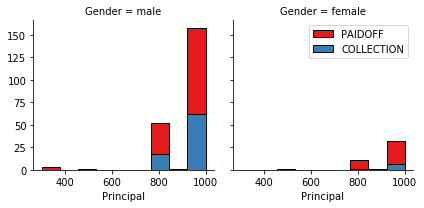

In [8]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

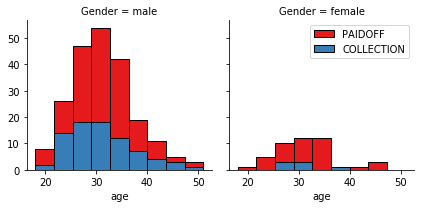

In [9]:

bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

## Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

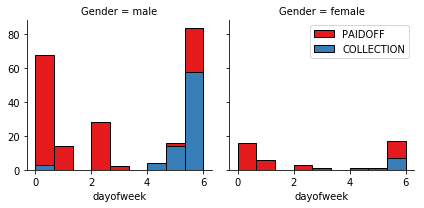

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### education Feature before Coding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### education Feature After Coding

In [16]:
df['education'].replace(to_replace=['High School or Below','college','Bechalor','Master or Above'], value=[1,2,3,4],inplace=True)
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,1
1,1000,30,33,1,3
2,1000,15,27,0,2
3,1000,30,28,1,2
4,1000,30,29,0,2


* Predicted column(loan_status)

In [17]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)


#### Define Feature

In [18]:
Feature = df[['Principal','terms','age','Gender','education']]
Feature.head()


,Principal,terms,age,Gender,education
0,1000,30,45,0,1
1,1000,30,33,1,3
2,1000,15,27,0,2
3,1000,30,28,1,2
4,1000,30,29,0,2


### Feature selection

Lets defind feature sets, X:

In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,education
0,1000,30,45,0,1
1,1000,30,33,1,3
2,1000,15,27,0,2
3,1000,30,28,1,2
4,1000,30,29,0,2


What are our lables?

In [20]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -0.99512471],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177,  1.83872837],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004,  0.42180183],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.42180183],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.42180183]])

### Train-Test Split  

In [22]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


# PART 2: Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)


### Training

In [23]:
# choose number of k. start with 4 for now.
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

### Predicting

In [24]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([0, 0, 0, 1, 0])

### Accuracy evaluation
* Accuracy classification score   
Accuracy classification score will be used as this is a multilabel classification case.  
it is a function that computes subset accuracy and it is equal to the jaccard_similarity_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.  
Other evaluation methods will be used later to evaluate the prediction of loan_test.csv set. (see PART 3)

In [25]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7608695652173914
Test set Accuracy:  0.7714285714285715


* jaccard index
Lets try jaccard index for accuracy evaluation.  
we can define jaccard as the size of the intersection divided by the size of the union of two label sets. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

In [26]:
print("jaccard index is:", jaccard_similarity_score(y_test, yhat))


jaccard index is: 0.7714285714285715


* F1_Score  
first build confusion matrix 

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 1 14]
 [ 2 53]]


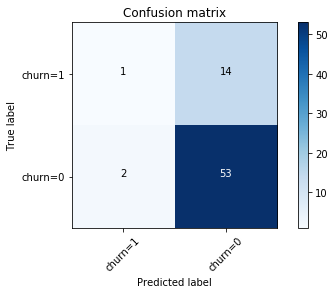

In [28]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [29]:
print('F1_score:', f1_score(y_test, yhat, average='weighted')) 

F1_score: 0.7064793130366899


### Determine the best K
The intial K value will be chosen first as K=1, then the model will be trained with train set. After that, accuracy will be calculated for Test set prediction results. This process will be repeated as we increase K value.

In [30]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc



array([0.66, 0.77, 0.69, 0.77, 0.77, 0.77, 0.74, 0.77, 0.74])

Plot  model accuracy  for Different number of Neighbors 


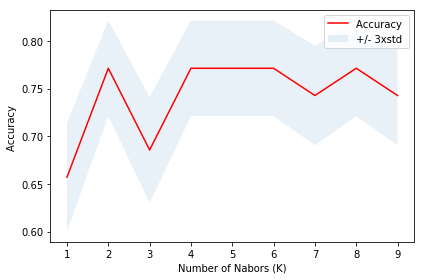

In [31]:
plt.plot(range(1,Ks),mean_acc,'r')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [32]:
best_K= mean_acc.argmax() + 1
print( "The best accuracy was with", mean_acc.max(), "with k=", best_K) 

The best accuracy was with 0.7714285714285715 with k= 2


# Decision Tree

### Modeling
We will first create an instance of the DecisionTreeClassifier called loanTree.
Inside of the classifier, specify criterion="entropy" so we can see the information gain of each node.

In [33]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Next, we will fit the data with the training feature matrix X_train and training response vector y_train

In [34]:
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Prediction
Let's make some predictions on the testing dataset and store it into a variable called predTree.

In [35]:
predTree = loanTree.predict(X_test)

You can print out predTree and y_test  to visually compare the prediction to the actual values.



In [36]:
print (predTree [0:5])
print (y_test [0:5])

[0 0 0 0 0]
[0 0 0 0 0]


### Evaluation
Next, let's import metrics from sklearn and check the accuracy of our model.

In [37]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.7857142857142857


1. jaccard index 

In [38]:
print("jaccard index is:", jaccard_similarity_score(y_test, predTree))


jaccard index is: 0.7857142857142857


2. F1_Score 
Plot Confusion matrix

Confusion matrix, without normalization
[[ 0 15]
 [ 0 55]]


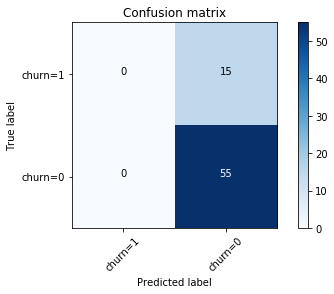

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predTree, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [40]:
print('F1_score:', f1_score(y_test, predTree, average='weighted')) 

F1_score: 0.6914285714285714


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Visualization
Lets visualize the tree

In [41]:
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y
%matplotlib inline 

In [42]:
##Skip this as we convert loan_status to numeric. Visualization requires catogrical data

#dot_data = StringIO()
#filename = "loanTree.png"
#featureNames = df.columns[0:5]
#targetNames = df["loan_status"].unique().tolist()
#out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png(filename)
#img = mpimg.imread(filename)
#plt.figure(figsize=(100, 200))
#plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [43]:
SFeature= df[['Principal','terms','age','Gender','education','loan_status']]
SFeature.head()

,Principal,terms,age,Gender,education,loan_status
0,1000,30,45,0,1,0
1,1000,30,33,1,3,0
2,1000,15,27,0,2,0
3,1000,30,28,1,2,0
4,1000,30,29,0,2,0


Lets look at the distribution of the classes based on age and Principal

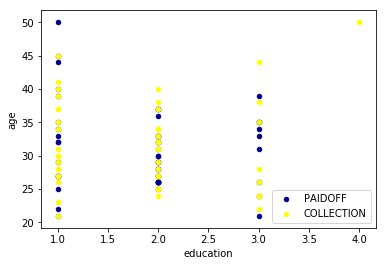

In [44]:
ax = SFeature[SFeature['loan_status'] == 0][0:50].plot(kind='scatter', x='education', y='age', color='DarkBlue', label='PAIDOFF');
SFeature[SFeature['loan_status'] == 1][0:50].plot(kind='scatter', x='education', y='age', color='Yellow', label='COLLECTION', ax=ax);
plt.show()

#### Modeling (SVM with Scikit-learn)
Use the default, RBF (Radial Basis Function).

In [45]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [46]:
# Predict the value
Syhat = clf.predict(X_test)
Syhat [0:5]

array([0, 0, 0, 0, 0])

#### Evaluation 
1. jaccard index 

In [47]:
print("jaccard index is:", jaccard_similarity_score(y_test, Syhat))


jaccard index is: 0.7857142857142857


2. F1_Score 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.79      1.00      0.88        55
           1       0.00      0.00      0.00        15

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[55  0]
 [15  0]]


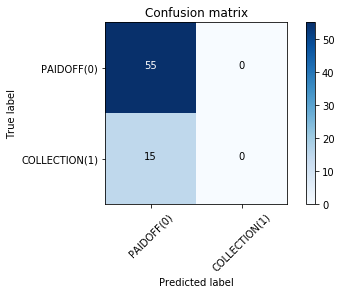

In [48]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, Syhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, Syhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(0)','COLLECTION(1)'],normalize= False,  title='Confusion matrix')

In [49]:
print('F1_score:' ,f1_score(y_test, Syhat, average='weighted')) 

F1_score: 0.6914285714285714


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Logistic Regression

skitlearn algorithm require the target data type to be integer. simply, use SVM sets (SX_train and Sy_train)

#### Training

In [50]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

#### Prediction
Now we can predict using our test set:

In [51]:
LRyhat = LR.predict(X_test)
LRyhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

Use Predict_Probe

In [52]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.56, 0.44],
       [0.62, 0.38],
       [0.6 , 0.4 ],
       [0.55, 0.45],
       [0.58, 0.42],
       [0.59, 0.41],
       [0.58, 0.42],
       [0.59, 0.41],
       [0.55, 0.45],
       [0.58, 0.42],
       [0.56, 0.44],
       [0.57, 0.43],
       [0.68, 0.32],
       [0.56, 0.44],
       [0.63, 0.37],
       [0.66, 0.34],
       [0.54, 0.46],
       [0.6 , 0.4 ],
       [0.56, 0.44],
       [0.58, 0.42],
       [0.63, 0.37],
       [0.57, 0.43],
       [0.55, 0.45],
       [0.61, 0.39],
       [0.67, 0.33],
       [0.56, 0.44],
       [0.56, 0.44],
       [0.7 , 0.3 ],
       [0.56, 0.44],
       [0.67, 0.33],
       [0.6 , 0.4 ],
       [0.61, 0.39],
       [0.61, 0.39],
       [0.58, 0.42],
       [0.68, 0.32],
       [0.61, 0.39],
       [0.56, 0.44],
       [0.62, 0.38],
       [0.62, 0.38],
       [0.61, 0.39],
       [0.56, 0.44],
       [0.58, 0.42],
       [0.62, 0.38],
       [0.56, 0.44],
       [0.6 , 0.4 ],
       [0.57, 0.43],
       [0.6 , 0.4 ],
       [0.57,

#### Evaluation
1. jaccard index

In [53]:
jaccard_similarity_score(y_test, LRyhat)

0.7857142857142857

2. F1_Score 

Confusion matrix, without normalization
[[ 0 15]
 [ 0 55]]


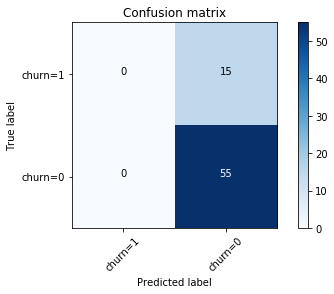

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, LRyhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [55]:
print('F1_score: ', f1_score(y_test, LRyhat, average='weighted') )

F1_score:  0.6914285714285714


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In logistic regression, the output can be the probability of customer churn is yes (or equals to 1). This probability is a value between 0 and 1. Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1.

In [56]:
log_loss(y_test, yhat_prob)

0.6009771839994061

# PART 3: Model Evaluation using Test set
## Data Preparation and Pre-processing

First, download and load the test set:

In [57]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-04 15:32:45--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-04 15:32:45 (160 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [58]:
tdf = pd.read_csv('loan_test.csv')
tdf.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [59]:
tdf.shape

(54, 10)

### Convert to date time object 

In [60]:
tdf['due_date'] = pd.to_datetime(tdf['due_date'])
tdf['effective_date'] = pd.to_datetime(tdf['effective_date'])


Let’s see how many of each class is in our data set 

In [61]:
tdf['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

###  Convert Categorical features to numerical values
* Weekday/Weekend Feature

In [62]:
# use Feature binarization to set a threshold values less then day 4
tdf['dayofweek'] = tdf['effective_date'].dt.dayofweek
tdf['weekend'] = tdf['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)


* Gender Feature

In [63]:
tdf['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)


* Education Feature  

In [64]:
tdf['education'].replace(to_replace=['High School or Below','college','Bechalor','Master or Above'], value=[1,2,3,4],inplace=True)
tdf.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,3,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,4,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,1,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,2,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,3,0,6,1


* Predicted column (loan_status)

In [65]:
tdf['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
tdf.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,0,1000,30,2016-09-08,2016-10-07,50,3,1,3,0
1,5,5,0,300,7,2016-09-09,2016-09-15,35,4,0,4,1
2,21,21,0,1000,30,2016-09-10,2016-10-09,43,1,1,5,1
3,24,24,0,1000,30,2016-09-10,2016-10-09,26,2,0,5,1
4,35,35,0,800,15,2016-09-11,2016-09-25,29,3,0,6,1


In [66]:
TFeature = tdf[['Principal','terms','age','Gender','education']]
TFeature.head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,3
1,300,7,35,0,4
2,1000,30,43,1,1
3,1000,30,26,0,2
4,800,15,29,0,3


### Feature selection

In [67]:
# Lets defind feature sets from Test set, T:
T = TFeature
T[0:5]

,Principal,terms,age,Gender,education
0,1000,30,50,1,3
1,300,7,35,0,4
2,1000,30,43,1,1
3,1000,30,26,0,2
4,800,15,29,0,3


In [68]:
# Prediction set, P:
P = tdf['loan_status'].values
P[0:5]

array([0, 0, 0, 0, 0])

In [69]:
# Normalize Data 
T= preprocessing.StandardScaler().fit(T).transform(T)
T[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


array([[ 0.49,  0.93,  3.06,  1.98,  1.44],
       [-3.56, -1.7 ,  0.53, -0.51,  2.67],
       [ 0.49,  0.93,  1.88,  1.98, -1.03],
       [ 0.49,  0.93, -0.98, -0.51,  0.21],
       [-0.67, -0.79, -0.48, -0.51,  1.44]])

## KNN Evaluation
best_K was calcilated before. Now it will be used to predict test set and then the results will be evaluated.
#### Training

In [70]:
# choose number of k.
k = best_K
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

#### Predicting

In [71]:
Phat = neigh.predict(T)
Phat[0:5]

array([0, 0, 0, 1, 0])

### Evaluation
1. jaccard index
Lets try jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection divided by the size of the union of two label sets. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.
 

In [72]:
print("jaccard index is:", jaccard_similarity_score(P, Phat))


jaccard index is: 0.7407407407407407


2. F1_Score  

Confusion matrix, without normalization
[[ 1 13]
 [ 1 39]]


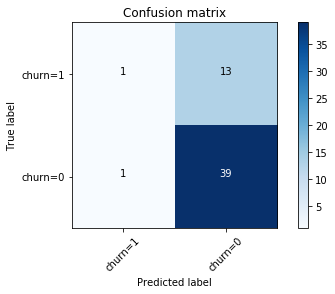

In [73]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(P, Phat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [74]:
print (classification_report(P, Phat))


              precision    recall  f1-score   support

           0       0.75      0.97      0.85        40
           1       0.50      0.07      0.12        14

   micro avg       0.74      0.74      0.74        54
   macro avg       0.62      0.52      0.49        54
weighted avg       0.69      0.74      0.66        54



Represent F1_Score: 

In [75]:
print('F1_score:', f1_score(P, Phat, average='weighted')) 

F1_score: 0.6604267310789049


## Decision Tree Evaluation 
#### Prediction

In [76]:
PpredTree = loanTree.predict(T)

#### Evaluation
1. jaccard index 

In [77]:
print("jaccard index is:", jaccard_similarity_score(P, PpredTree))


jaccard index is: 0.7407407407407407


2. F1_Score 
Plot Confusion matrix

Confusion matrix, without normalization
[[ 0 14]
 [ 0 40]]


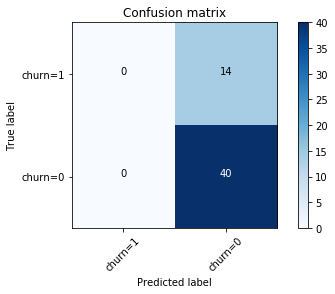

In [78]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(P, PpredTree, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [79]:
print (classification_report(P, PpredTree))


              precision    recall  f1-score   support

           0       0.74      1.00      0.85        40
           1       0.00      0.00      0.00        14

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Represent F1_Score: 

In [80]:
print('F1_score:', f1_score(P, PpredTree, average='weighted')) 

F1_score: 0.6304176516942475


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Support Vector Machines Evaluation

In [81]:
SFeature=tdf[['education','Principal','terms','age','Gender','loan_status']]
SFeature.head()


,education,Principal,terms,age,Gender,loan_status
0,3,1000,30,50,1,0
1,4,300,7,35,0,0
2,1,1000,30,43,1,0
3,2,1000,30,26,0,0
4,3,800,15,29,0,0


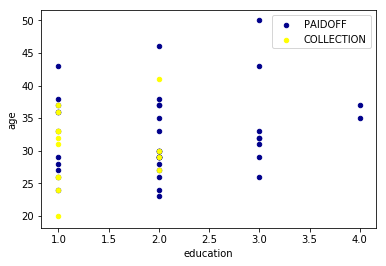

In [82]:
ax = SFeature[SFeature['loan_status'] == 0][0:50].plot(kind='scatter', x='education', y='age', color='DarkBlue', label='PAIDOFF');
SFeature[SFeature['loan_status'] == 1][0:50].plot(kind='scatter', x='education', y='age', color='Yellow', label='COLLECTION', ax=ax);
plt.show()

In [83]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [84]:
# Predict the value
Syhat = clf.predict(T)
Syhat [0:5]

array([0, 0, 0, 0, 0])

#### Evaluation
1. jaccard index 

In [85]:
print("jaccard index is:", jaccard_similarity_score(P, Syhat))


jaccard index is: 0.7407407407407407


2. F1_Score 
Plot Confusion matrix

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.74      1.00      0.85        40
           1       0.00      0.00      0.00        14

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54

Confusion matrix, without normalization
[[40  0]
 [14  0]]


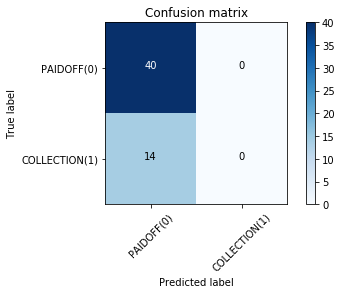

In [86]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(P, Syhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(P, Syhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(0)','COLLECTION(1)'],normalize= False,  title='Confusion matrix')

In [87]:
print('F1_score:', f1_score(P, Syhat, average='weighted')) 

F1_score: 0.6304176516942475


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Logistic Regression Evaluation
#### Prediction

In [88]:
Lyhat = LR.predict(T)
Lyhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [89]:
Lyhat_prob = LR.predict_proba(T)
Lyhat_prob

array([[0.66, 0.34],
       [0.66, 0.34],
       [0.64, 0.36],
       [0.55, 0.45],
       [0.6 , 0.4 ],
       [0.62, 0.38],
       [0.58, 0.42],
       [0.57, 0.43],
       [0.64, 0.36],
       [0.61, 0.39],
       [0.59, 0.41],
       [0.66, 0.34],
       [0.57, 0.43],
       [0.63, 0.37],
       [0.63, 0.37],
       [0.57, 0.43],
       [0.64, 0.36],
       [0.66, 0.34],
       [0.58, 0.42],
       [0.6 , 0.4 ],
       [0.56, 0.44],
       [0.6 , 0.4 ],
       [0.67, 0.33],
       [0.59, 0.41],
       [0.59, 0.41],
       [0.57, 0.43],
       [0.58, 0.42],
       [0.6 , 0.4 ],
       [0.57, 0.43],
       [0.56, 0.44],
       [0.56, 0.44],
       [0.61, 0.39],
       [0.56, 0.44],
       [0.56, 0.44],
       [0.61, 0.39],
       [0.56, 0.44],
       [0.56, 0.44],
       [0.59, 0.41],
       [0.63, 0.37],
       [0.61, 0.39],
       [0.57, 0.43],
       [0.64, 0.36],
       [0.63, 0.37],
       [0.56, 0.44],
       [0.64, 0.36],
       [0.53, 0.47],
       [0.58, 0.42],
       [0.59,

#### Evaluation
1. jaccard index

In [90]:
jaccard_similarity_score(P, Lyhat)

0.7407407407407407

2. F1_Score 

Confusion matrix, without normalization
[[ 0 14]
 [ 0 40]]


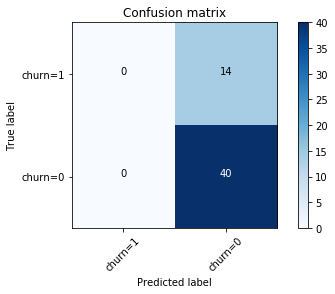

In [91]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(P, Lyhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [92]:
print (classification_report(P, Lyhat))


              precision    recall  f1-score   support

           0       0.74      1.00      0.85        40
           1       0.00      0.00      0.00        14

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [93]:
print('F1_score: ', f1_score(P, Lyhat, average='weighted') )

F1_score:  0.6304176516942475


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3. Log loss

In [94]:
print('log loss:',log_loss(P, Lyhat_prob))

log loss: 0.6120386088876141


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                |0.74     | 0.66     | NA      |
| Decision Tree      |0.74     | 0.63 x   | NA      |
| SVM                |0.74     |0.63      | NA      |
| LogisticRegression |0.74     |0.63      | 0.612   |

This Project was done by: 
## Amnah Bukair
willing to hear your opinion and suggestion if any. <3